# Precipitation Frequency Table For Nested Hyetograph

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI and the durations of interest.

__Output__: A spreadsheet with sheets for each recurrence interval hyetograph shape 

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [51]:
import sys
sys.path.append('../../core')
from hydromet import* #Using new hydromet_stratified

### Parameters: 

#### Papermill (site specific):

In [52]:

## Filenames and fields:
Project_Area = 'DesPlaines'          # Project area name
Pluvial_Model = 'P03'                # Pluvial model name
BCN = 'D01'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'
polygon = 'Addison_domain.shp'           # Shapefile name
filter_field = 'Domain'          #HUC12 Attribute with in the vector polygon used for data selection
select_data = BCN                    # Value within the filter_field used for data selection


## Paths:
root_dir = pl.Path(os.getcwd())
datarepository_dir = root_dir.parent.parent/'DataRepository'
polygon_dir = root_dir/'Inputs'/polygon
outputs_dir = root_dir/'Outputs'


brute_force_projection = None

##### Convert all paths to objects:

In [53]:
datarepository_dir = pl.Path(datarepository_dir)
polygon_dir = pl.Path(polygon_dir)
outputs_dir = pl.Path(outputs_dir)
polygon_dir

WindowsPath('D:/git/new_2dble/notebooks/pluvial/Inputs/Addison_domain.shp')

#### Global (project specific):

In [54]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

durations = ['05m' , '10m' ,  '15m' , '30m' ,'60m'  ,'02h' , '03h' ,'06h', '12h','24h'] #'05m' , '10m' ,  '15m' , '30m' ,'60m'  ,'02h' , '03h' ,'06h', '12h' ,'04d'
dur_names = ['5min','10min', '15min','30min','60min','2hr' , '3hr' ,'6hr', '12hr','24hr']  # '5min','10min', '15min','30min','60min','2hr' , '3hr' ,'6hr', '12hr',  '96hr'

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'

verbose = True

## Read Vector Polygon:

### Load as a geodataframe:

In [55]:
gdf = gpd.read_file(polygon_dir)
check_attributes(gdf)

gdf.head(1)

,Domain,Centroid_X,Centroid_Y,geometry
0,D01,-87.911686,41.900325,"POLYGON ((1085471.218 1928481.372, 1085503.920..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [57]:
print('Original Coordinate Reference System:', gdf.crs)
with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))
        
vector_crs_prj =gdf.crs

Original Coordinate Reference System: {'proj': 'tmerc', 'lat_0': 36.66666666666666, 'lon_0': -88.33333333333333, 'k': 0.999975, 'x_0': 300000, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'us-ft', 'no_defs': True}
Vector Layer crs = +proj=tmerc +lat_0=36.66666666666666 +lon_0=-88.33333333333333 +k=0.999975 +x_0=300000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs=True 


### Extract the area of interest, reproject, and plot:

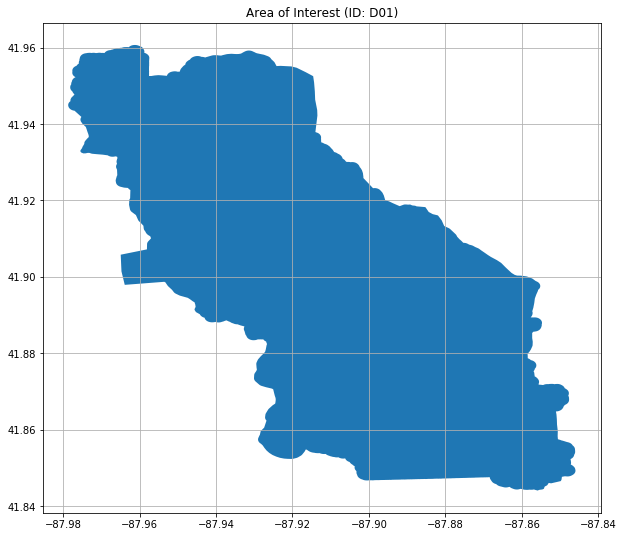

In [58]:
gdf1 = gdf.loc[gdf[filter_field] == select_data].copy()

gdf1.crs = vector_crs_prj
    
geo_df = gdf1.to_crs(epsg = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, filter_field)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           2
Region           1
Percent_area     100.0


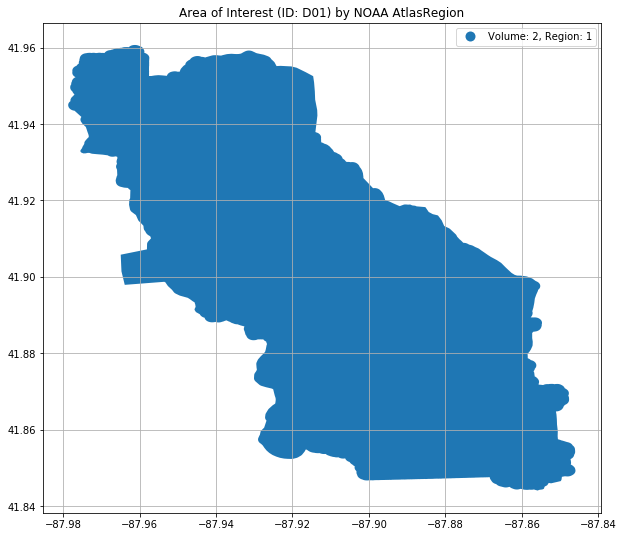

In [59]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']

### Load Atlas 14 volume code from json:

In [60]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: orb


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [61]:
noaa_url = 'https://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d) and ('l.zip' not in d) and ('u.zip' not in d)]
    copy_zips.append(zips)
    if verbose: print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

#Added by Mark Bartlett 
#Parse out the file name by using split functions
for i, zip_name in enumerate(all_zips_list):
    all_zips_list[i]= zip_name.split("\"", 1)[1].split("\"", 1)[0]

10 files found for 05m
10 files found for 10m
10 files found for 15m
10 files found for 30m
10 files found for 60m
10 files found for 02h
10 files found for 03h
10 files found for 06h
10 files found for 12h
10 files found for 24h


### Iterate through zip files and build a table:

In [62]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

0 orb1yr05ma.zip
1 orb2yr05ma.zip
2 orb5yr05ma.zip
3 orb10yr05ma.zip
4 orb25yr05ma.zip
5 orb50yr05ma.zip
6 orb100yr05ma.zip
7 orb200yr05ma.zip
8 orb500yr05ma.zip
9 orb1000yr05ma.zip
10 orb1yr10ma.zip
11 orb2yr10ma.zip
12 orb5yr10ma.zip
13 orb10yr10ma.zip
14 orb25yr10ma.zip
15 orb50yr10ma.zip
16 orb100yr10ma.zip
17 orb200yr10ma.zip
18 orb500yr10ma.zip
19 orb1000yr10ma.zip
20 orb1yr15ma.zip
21 orb2yr15ma.zip
22 orb5yr15ma.zip
23 orb10yr15ma.zip
24 orb25yr15ma.zip
25 orb50yr15ma.zip
26 orb100yr15ma.zip
27 orb200yr15ma.zip
28 orb500yr15ma.zip
29 orb1000yr15ma.zip
30 orb1yr30ma.zip
31 orb2yr30ma.zip
32 orb5yr30ma.zip
33 orb10yr30ma.zip
34 orb25yr30ma.zip
35 orb50yr30ma.zip
36 orb100yr30ma.zip
37 orb200yr30ma.zip
38 orb500yr30ma.zip
39 orb1000yr30ma.zip
40 orb1yr60ma.zip
41 orb2yr60ma.zip
42 orb5yr60ma.zip
43 orb10yr60ma.zip
44 orb25yr60ma.zip
45 orb50yr60ma.zip
46 orb100yr60ma.zip
47 orb200yr60ma.zip
48 orb500yr60ma.zip
49 orb1000yr60ma.zip
50 orb1yr02ha.zip
51 orb2yr02ha.zip
52 orb5yr02ha.

,region,TR,duration,statistic,value
0,orb,1,05m,Expected Value,0.387
1,orb,2,05m,Expected Value,0.454
2,orb,5,05m,Expected Value,0.535
3,orb,10,05m,Expected Value,0.611
4,orb,25,05m,Expected Value,0.701


None


In [63]:
df.head(20)

,region,TR,duration,statistic,value
0,orb,1,05m,Expected Value,0.387
1,orb,2,05m,Expected Value,0.454
2,orb,5,05m,Expected Value,0.535
3,orb,10,05m,Expected Value,0.611
4,orb,25,05m,Expected Value,0.701
5,orb,50,05m,Expected Value,0.779
6,orb,100,05m,Expected Value,0.853
7,orb,200,05m,Expected Value,0.933
8,orb,500,05m,Expected Value,1.040
9,orb,1000,05m,Expected Value,1.135


In [64]:
##for testing purposes
c_df.loc[evnt][['duration','value']].set_index('duration')

,value
duration,
05m,1.135
10m,1.653
15m,2.066
30m,3.096
60m,4.349
02h,5.352
03h,5.943
06h,8.509
12h,9.420


## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [ ]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save:

---

### Put reccurrence intervals through NRCS nested hyetograph function 

In [35]:
c_df = df[df['statistic'] =='Expected Value'].set_index('TR')
hyetos = {}
events_hyeto = ['2','5','10','25','50','100','200','500','1000']
for evnt in events_hyeto:
    precip_df = c_df.loc[evnt][['duration','value']].set_index('duration')
    hyetos[evnt] = precip_hyetograph_nrcs(precip_df)   

#### Plot to check

In [46]:
hyetos['100']

,ratio,slope,t_step
time,,,
0,0.000000,NaN,0.0
1,0.001115,0.011153,0.1
2,0.002236,0.011206,0.2
3,0.003362,0.011258,0.3
4,0.004493,0.011310,0.4
...,...,...,...
236,0.995507,0.011363,23.6
237,0.996638,0.011310,23.7
238,0.997764,0.011258,23.8


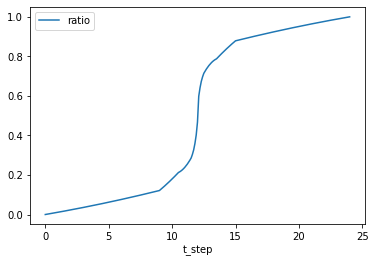

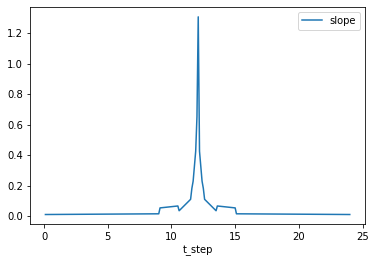

In [44]:
hyetos['100'].plot('t_step','ratio')
hyetos['100'].plot('t_step','slope')

#### Save distributions for incorporation into stratified table

In [50]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}__nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(events_hyeto):
    hyetos[d].to_excel(writer, sheet_name = 'nrcs_hye_{}'.format(events_hyeto[i]))
    print(table)

writer.save()

         ratio     slope
Tr                      
0.0   0.000000       NaN
0.1   0.000806  0.008063
0.2   0.001627  0.008203
0.3   0.002461  0.008344
0.4   0.003309  0.008484
...        ...       ...
23.6  0.996691  0.008625
23.7  0.997539  0.008484
23.8  0.998373  0.008344
23.9  0.999194  0.008203
24.0  1.000000  0.008063

[241 rows x 2 columns]
         ratio     slope
Tr                      
0.0   0.000000       NaN
0.1   0.000806  0.008063
0.2   0.001627  0.008203
0.3   0.002461  0.008344
0.4   0.003309  0.008484
...        ...       ...
23.6  0.996691  0.008625
23.7  0.997539  0.008484
23.8  0.998373  0.008344
23.9  0.999194  0.008203
24.0  1.000000  0.008063

[241 rows x 2 columns]
         ratio     slope
Tr                      
0.0   0.000000       NaN
0.1   0.000806  0.008063
0.2   0.001627  0.008203
0.3   0.002461  0.008344
0.4   0.003309  0.008484
...        ...       ...
23.6  0.996691  0.008625
23.7  0.997539  0.008484
23.8  0.998373  0.008344
23.9  0.999194  0.008203
24